In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import os

# ---------------------------------------------------
# 0. Load dataset
# ---------------------------------------------------
FILE_PATH = "/kaggle/input/gk-data/GK.csv"
df = pd.read_csv(FILE_PATH)

# ---------------------------------------------------
# 1. Filter out non-positive market values
# ---------------------------------------------------
df = df[df["MarketValue"] > 0].copy()

# ---------------------------------------------------
# 2. Log-transform MarketValue (optional)
# ---------------------------------------------------
df['LogMarketValue'] = np.log(df['MarketValue'])

# ---------------------------------------------------
# 3. Feature selection
# ---------------------------------------------------
selected_features = [
    'Overall rating', 'Potential', 'International reputation', 'Reactions', 'Shot power',"Saves","Minutes","Save Percentage","Growth","Losses",
    'Wins', 'Clean Sheets', 'league_score', 'team_score', 'Age', 'GK Reflexes',
    'GK Diving', 'GK Handling', 'GK Positioning', 'GK Kicking','Value'
]


# ---------------------------------------------------
# 4. Prepare X and y
# ---------------------------------------------------
X = df[selected_features]
y = df['MarketValue']
value_feature = df['Value']  # we need it for the extra filtering

# ---------------------------------------------------
# 5. Handle missing values
# ---------------------------------------------------
X = X.fillna(X.median())

# ---------------------------------------------------
# 6. Outlier Removal
# ---------------------------------------------------

# ---------------------------------------------------
# 7. Rebuild cleaned df
# ---------------------------------------------------
df_clean = X.copy()
df_clean['MarketValue'] = y

# ---------------------------------------------------
# 8. Define Segment boundaries (low, mid, high)
# ---------------------------------------------------
bins = [0, 1e6, 20e6, float("inf")]
labels = ["low", "mid", "high"]

df_clean["Segment"] = pd.cut(df_clean["MarketValue"], bins=bins, labels=labels)

# ---------------------------------------------------
# 9. Split into segments
# ---------------------------------------------------
df_low  = df_clean[df_clean["Segment"] == "low"].copy()
df_mid  = df_clean[df_clean["Segment"] == "mid"].copy()
df_high = df_clean[df_clean["Segment"] == "high"].copy()

print(f"Low segment:  {len(df_low)} players")
print(f"Mid segment:  {len(df_mid)} players")
print(f"High segment: {len(df_high)} players")
# ---------------------------------------------------
# 1. Split X and log(y) into train/test
# ---------------------------------------------------
X = df_clean[selected_features]
y_raw = df_clean['MarketValue'] 
X_train, X_test, y_train, y_test = train_test_split(
    X, y_raw, test_size=0.2, random_state=42
)
y_log = np.log(df_clean['MarketValue'])

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

Low segment:  227 players
Mid segment:  163 players
High segment: 20 players


⚠️ Dropping corrupted/nested columns: []

📊 XGBoost Model Performance (Fixed Params):
MAE: 1357409.196
RMSE: 2859486.298
R²: 0.899
RMSPE: 166.153%


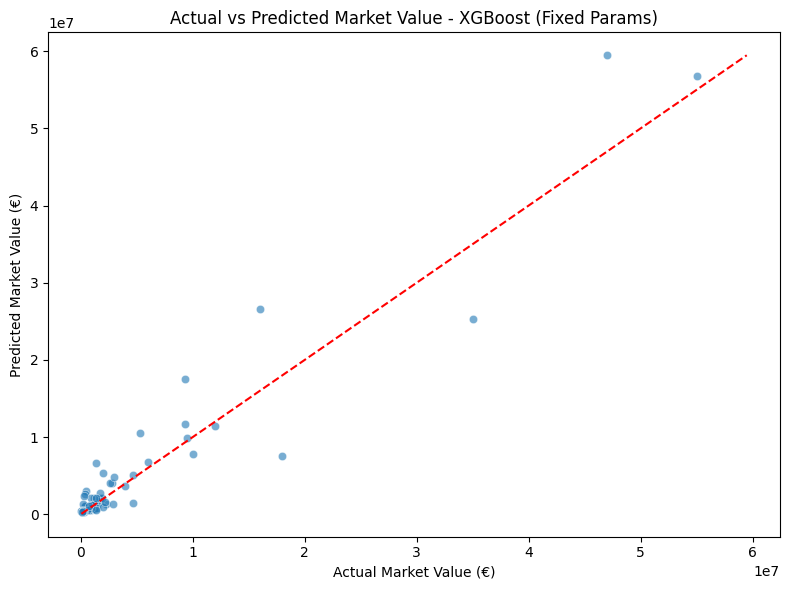

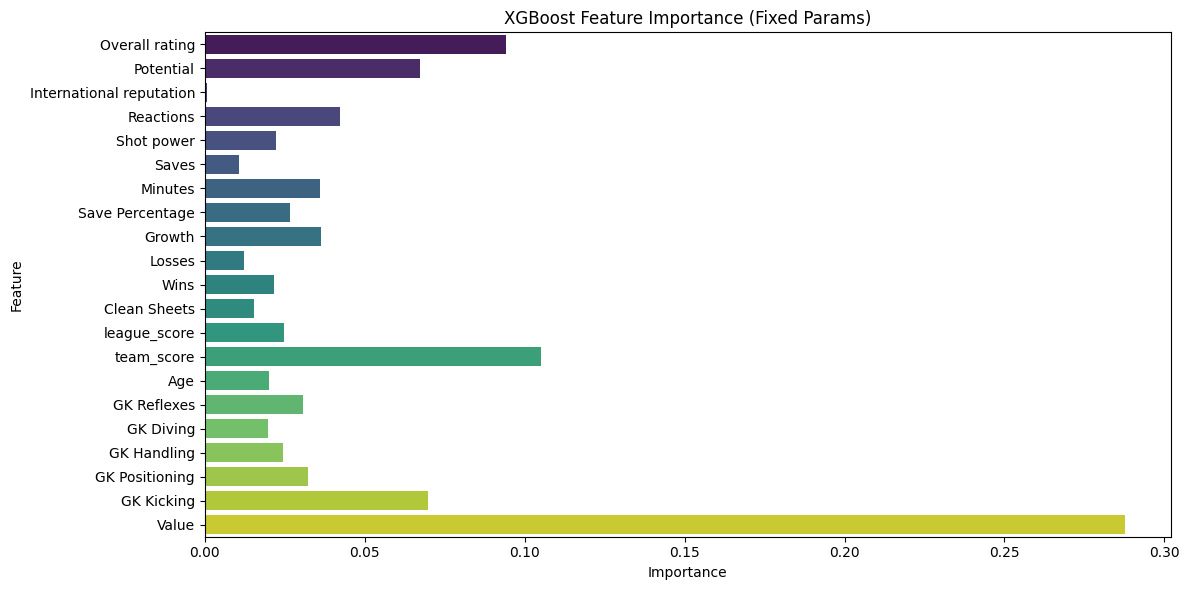

In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# ---------------------------------------------------
# Define Plot Directory
# ---------------------------------------------------
plot_dir = "plots/gk_xgboost_fixed"
os.makedirs(plot_dir, exist_ok=True)

# ---------------------------------------------------
# Drop corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
print("⚠️ Dropping corrupted/nested columns:", corrupted_cols)

X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# Impute missing values with median
# ---------------------------------------------------
imputer = SimpleImputer(strategy='median')
X_train_clean = pd.DataFrame(imputer.fit_transform(X_train_clean), columns=X_train_clean.columns)
X_test_clean  = pd.DataFrame(imputer.transform(X_test_clean), columns=X_test_clean.columns)

# ---------------------------------------------------
# Train XGBoost with Fixed Best Parameters
# ---------------------------------------------------
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train_clean, y_train)

# ---------------------------------------------------
# Predict
# ---------------------------------------------------
y_pred = xgb_model.predict(X_test_clean)

# ---------------------------------------------------
# Metrics
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
rmspe_val = rmspe(y_test.reset_index(drop=True), pd.Series(y_pred))

print("\n📊 XGBoost Model Performance (Fixed Params):")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"RMSPE: {rmspe_val:.3f}%")

# ---------------------------------------------------
# Plot: Actual vs Predicted
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - XGBoost (Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_xgboost_fixed.png"))
plt.show()

# ---------------------------------------------------
# Feature Importance
# ---------------------------------------------------
importances = xgb_model.feature_importances_

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=X_train_clean.columns, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_xgboost_fixed.png"))
plt.show()


⚠️ Dropping corrupted/nested columns: []

📊 XGBoost Model Performance (Log Target, Fixed Params):
MAE (log): 0.372
RMSE (log): 0.475
R² (log): 0.900
RMSPE (log): 3.477%

📊 XGBoost Model Performance (Original Scale):
MAE: 1532561.102
RMSE: 4223970.313
R²: 0.779
RMSPE: 62.284%


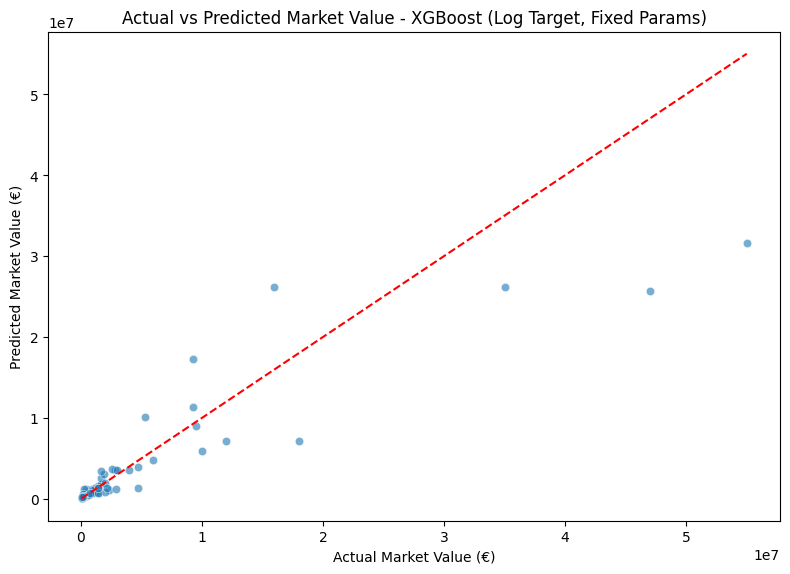

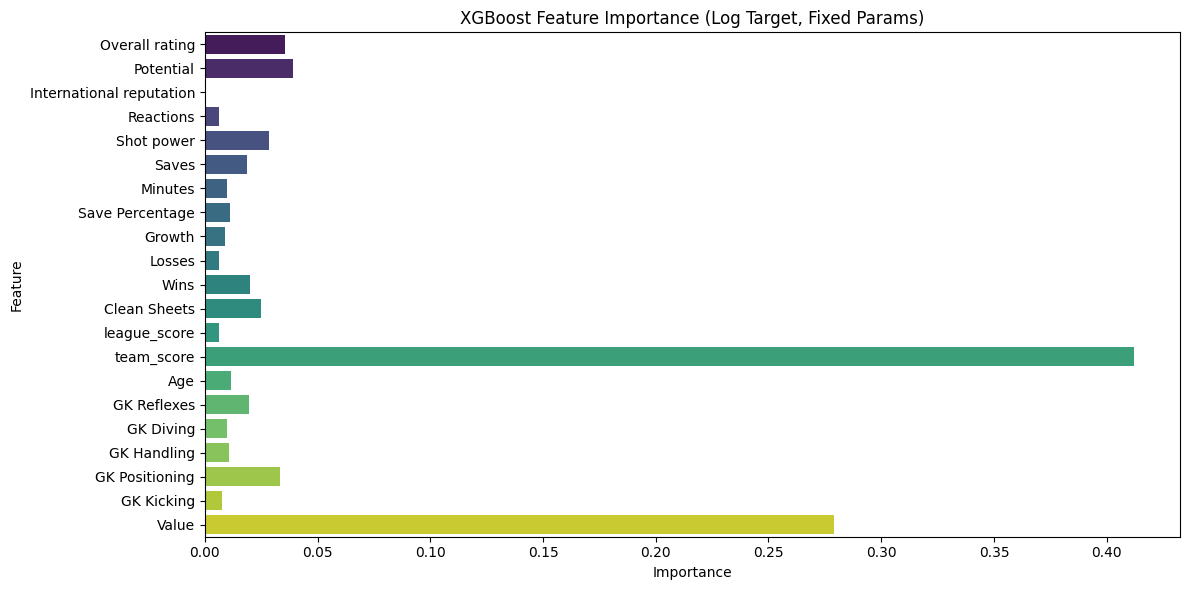

In [16]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# ---------------------------------------------------
# Define Plot Directory
# ---------------------------------------------------
plot_dir = "plots/gk_xgboost_fixed_log"
os.makedirs(plot_dir, exist_ok=True)

# ---------------------------------------------------
# Drop corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
print("⚠️ Dropping corrupted/nested columns:", corrupted_cols)

X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# Impute missing values with median
# ---------------------------------------------------
imputer = SimpleImputer(strategy='median')
X_train_clean = pd.DataFrame(imputer.fit_transform(X_train_clean), columns=X_train_clean.columns)
X_test_clean  = pd.DataFrame(imputer.transform(X_test_clean), columns=X_test_clean.columns)

# ---------------------------------------------------
# Transform Target to Log Scale
# ---------------------------------------------------
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# ---------------------------------------------------
# XGBoost Regressor with Best Params
# ---------------------------------------------------
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train_clean, y_train_log)

# ---------------------------------------------------
# Predict
# ---------------------------------------------------
y_pred_log = xgb_model.predict(X_test_clean)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

# ---------------------------------------------------
# Metrics
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# Log-scale metrics
mae_log = mean_absolute_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2_log = r2_score(y_test_log, y_pred_log)
rmspe_log = rmspe(y_test_log, y_pred_log)

# Original scale metrics
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)
rmspe_val = rmspe(y_test_original.reset_index(drop=True), pd.Series(y_pred))

# ---------------------------------------------------
# Print Metrics
# ---------------------------------------------------
print("\n📊 XGBoost Model Performance (Log Target, Fixed Params):")
print(f"MAE (log): {mae_log:.3f}")
print(f"RMSE (log): {rmse_log:.3f}")
print(f"R² (log): {r2_log:.3f}")
print(f"RMSPE (log): {rmspe_log:.3f}%")

print("\n📊 XGBoost Model Performance (Original Scale):")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"RMSPE: {rmspe_val:.3f}%")

# ---------------------------------------------------
# Plot: Actual vs Predicted
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_original, y=y_pred, alpha=0.6)
lims = [min(y_test_original.min(), y_pred.min()), max(y_test_original.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - XGBoost (Log Target, Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_xgboost_fixed_log.png"))
plt.show()

# ---------------------------------------------------
# Feature Importance
# ---------------------------------------------------
importances = xgb_model.feature_importances_

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=X_train_clean.columns, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (Log Target, Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_xgboost_fixed_log.png"))
plt.show()


⚠️ Dropping corrupted/nested columns: []

📊 Random Forest Model Performance (Fixed Params):
MAE: 1173965.602
RMSE: 2166531.997
R²: 0.942
RMSPE: 127.088%


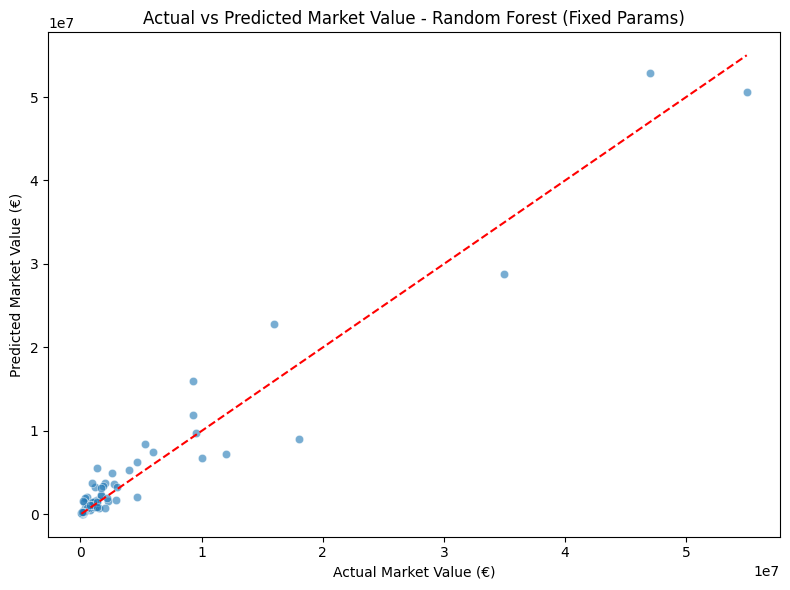

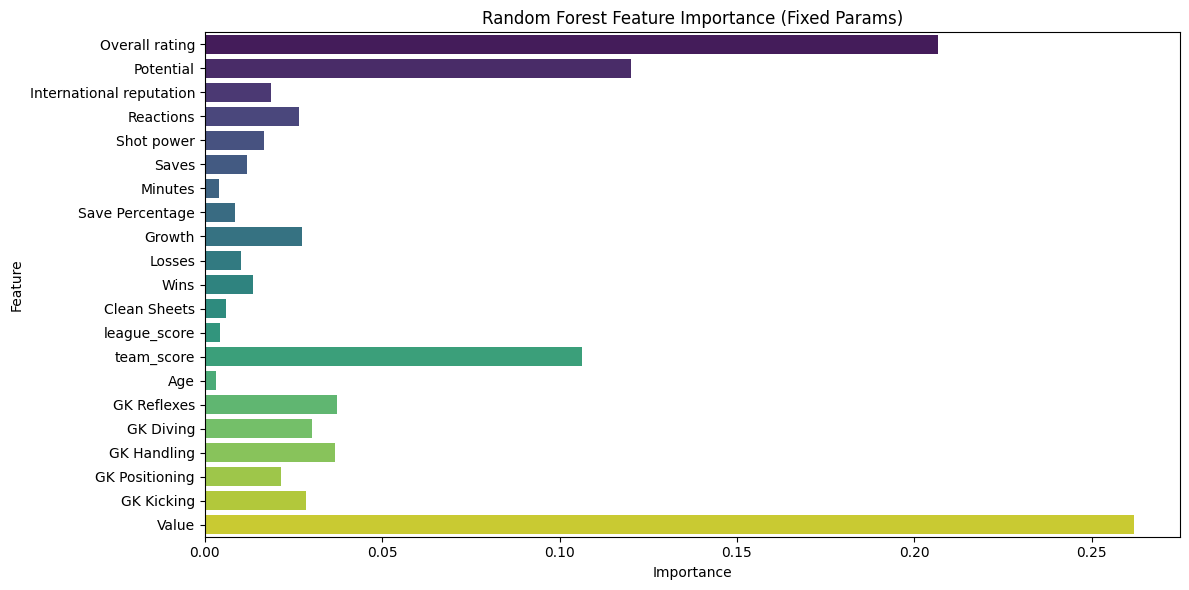

In [15]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------------------------------
# Define Plot Directory
# ---------------------------------------------------
plot_dir = "plots/gk_randomforest_fixed"
os.makedirs(plot_dir, exist_ok=True)

# ---------------------------------------------------
# Drop corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
print("⚠️ Dropping corrupted/nested columns:", corrupted_cols)

X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# Impute missing values with median
# ---------------------------------------------------
imputer = SimpleImputer(strategy='median')
X_train_clean = pd.DataFrame(imputer.fit_transform(X_train_clean), columns=X_train_clean.columns)
X_test_clean  = pd.DataFrame(imputer.transform(X_test_clean), columns=X_test_clean.columns)

# ---------------------------------------------------
# Train Random Forest (Fixed Best Params)
# ---------------------------------------------------
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    max_features=0.5,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42
)

rf_model.fit(X_train_clean, y_train)

# ---------------------------------------------------
# Predict
# ---------------------------------------------------
y_pred = rf_model.predict(X_test_clean)

# ---------------------------------------------------
# Metrics
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
rmspe_val = rmspe(y_test.reset_index(drop=True), pd.Series(y_pred))

# ---------------------------------------------------
# Print Metrics
# ---------------------------------------------------
print("\n📊 Random Forest Model Performance (Fixed Params):")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"RMSPE: {rmspe_val:.3f}%")

# ---------------------------------------------------
# Plot: Actual vs Predicted
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - Random Forest (Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_rf_fixed.png"))
plt.show()

# ---------------------------------------------------
# Feature Importance
# ---------------------------------------------------
importances = rf_model.feature_importances_

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=X_train_clean.columns, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance (Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_rf_fixed.png"))
plt.show()


⚠️ Dropping corrupted/nested columns: []


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



📊 Random Forest Model Performance (Log Target, Fixed Params):
MAE (log): 0.334
RMSE (log): 0.459
R² (log): 0.907
RMSPE: 3.434%

📊 Random Forest Model Performance (Original Scale):
MAE: 1171542.000
RMSE: 2933230.887
R²: 0.893
RMSPE: 77.292%


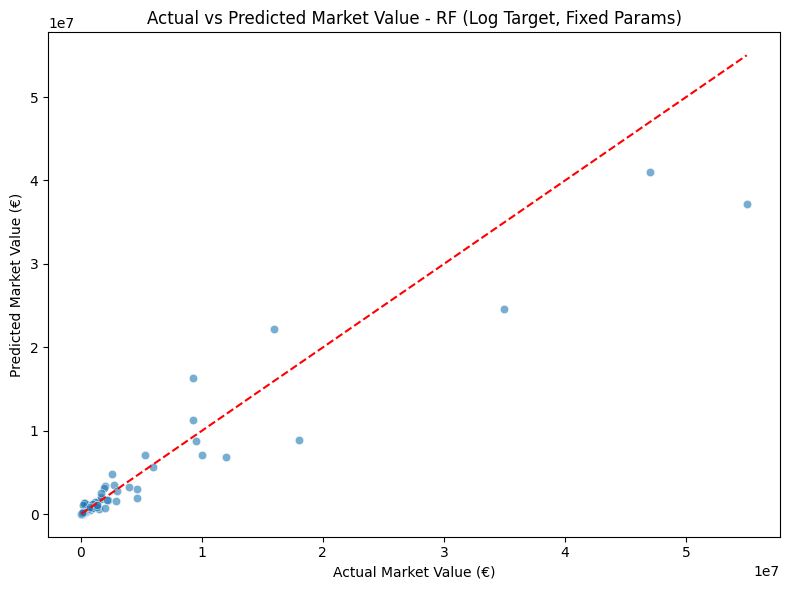

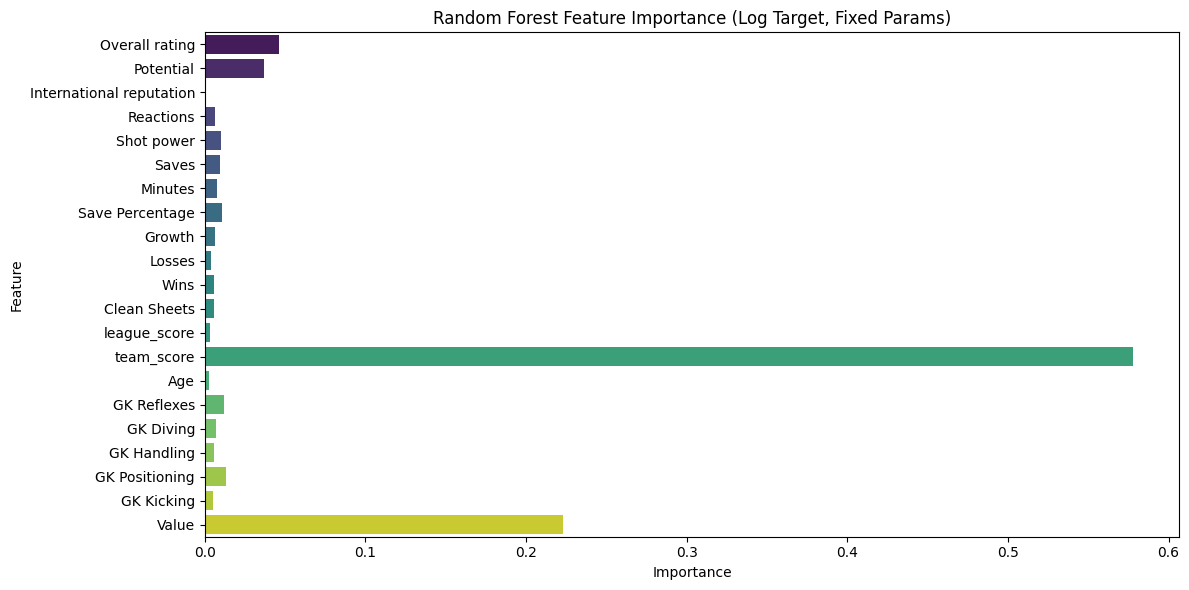

In [26]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------------------------------
# Define Plot Directory
# ---------------------------------------------------
plot_dir = "plots/gk_randomforest_fixed_log"
os.makedirs(plot_dir, exist_ok=True)

# ---------------------------------------------------
# Drop corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
print("⚠️ Dropping corrupted/nested columns:", corrupted_cols)

X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# Impute missing values with median
# ---------------------------------------------------
imputer = SimpleImputer(strategy='median')
X_train_clean = pd.DataFrame(imputer.fit_transform(X_train_clean), columns=X_train_clean.columns)
X_test_clean  = pd.DataFrame(imputer.transform(X_test_clean), columns=X_test_clean.columns)

# ---------------------------------------------------
# Log-transform the target
# ---------------------------------------------------
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# ---------------------------------------------------
# Define Random Forest with Best Parameters
# ---------------------------------------------------
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    max_features='auto',
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42
)

rf_model.fit(X_train_clean, y_train_log)

# ---------------------------------------------------
# Predict
# ---------------------------------------------------
y_pred_log = rf_model.predict(X_test_clean)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

# ---------------------------------------------------
# Metrics
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# Log-scale metrics
mae_log = mean_absolute_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2_log = r2_score(y_test_log, y_pred_log)
rmspe_log=rmspe(y_test_log,y_pred_log)
# Normal-scale metrics
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)
rmspe_val = rmspe(y_test_original.reset_index(drop=True), pd.Series(y_pred))

# ---------------------------------------------------
# Print Metrics
# ---------------------------------------------------
print("\n📊 Random Forest Model Performance (Log Target, Fixed Params):")
print(f"MAE (log): {mae_log:.3f}")
print(f"RMSE (log): {rmse_log:.3f}")
print(f"R² (log): {r2_log:.3f}")
print(f"RMSPE: {rmspe_log:.3f}%")

print("\n📊 Random Forest Model Performance (Original Scale):")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"RMSPE: {rmspe_val:.3f}%")

# ---------------------------------------------------
# Plot: Actual vs Predicted
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_original, y=y_pred, alpha=0.6)
lims = [min(y_test_original.min(), y_pred.min()), max(y_test_original.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - RF (Log Target, Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_rf_fixed_log.png"))
plt.show()

# ---------------------------------------------------
# Feature Importance
# ---------------------------------------------------
importances = rf_model.feature_importances_

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=X_train_clean.columns, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance (Log Target, Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_rf_fixed_log.png"))
plt.show()


⚠️ Dropping corrupted/nested columns: []

📊 Stacking Regressor Performance (Fixed Best Params):
MAE: 2393350.74
RMSE: 4674017.41
R²: 0.730
RMSPE: 606.52%


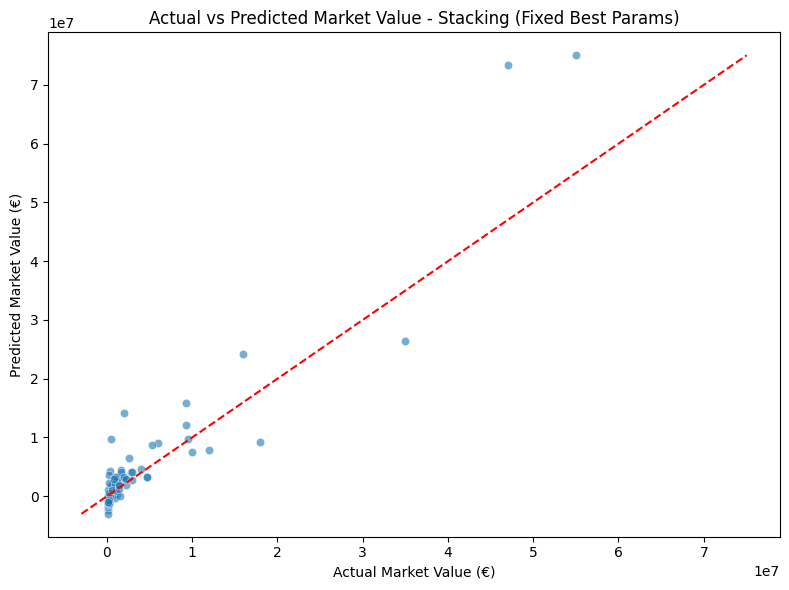

In [25]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suppress warnings from Ridge
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------------------------------------------------
# Define Plot Directory
# ---------------------------------------------------
plot_dir = "plots/gk_stacking_fixed_params"
os.makedirs(plot_dir, exist_ok=True)

# ---------------------------------------------------
# Drop corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
print("⚠️ Dropping corrupted/nested columns:", corrupted_cols)

X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# Impute missing values with median
# ---------------------------------------------------
imputer = SimpleImputer(strategy='median')
X_train_clean = pd.DataFrame(imputer.fit_transform(X_train_clean), columns=X_train_clean.columns)
X_test_clean  = pd.DataFrame(imputer.transform(X_test_clean), columns=X_test_clean.columns)

# ---------------------------------------------------
# Fixed Parameter Models
# ---------------------------------------------------
rf_best = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42
)

xgb_best = XGBRegressor(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

meta_learner = make_pipeline(
    StandardScaler(),
    Ridge(alpha=10.0)
)

stack = StackingRegressor(
    estimators=[('rf', rf_best), ('xgb', xgb_best)],
    final_estimator=meta_learner,
    passthrough=True
)

# ---------------------------------------------------
# Fit model and predict
# ---------------------------------------------------
stack.fit(X_train_clean, y_train)
y_pred = stack.predict(X_test_clean)

# ---------------------------------------------------
# Metrics
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
rmspe_val = rmspe(y_test.reset_index(drop=True), pd.Series(y_pred))

# ---------------------------------------------------
# Print Metrics
# ---------------------------------------------------
print("\n📊 Stacking Regressor Performance (Fixed Best Params):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")
print(f"RMSPE: {rmspe_val:.2f}%")

# ---------------------------------------------------
# Plot: Actual vs Predicted
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - Stacking (Fixed Best Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_stacking_fixed_params.png"))
plt.show()


⚠️ Dropping corrupted/nested columns: []

📊 Stacking Regressor Performance (Log Target, Fixed Best Params):
MAE (log): 0.368
RMSE (log): 0.493
R² (log): 0.892
RMSPE: 3.63

📊 Stacking Regressor Performance (Original Scale):
MAE: 2647370.99
RMSE: 11892404.90
R²: -0.751
RMSPE: 84.58%


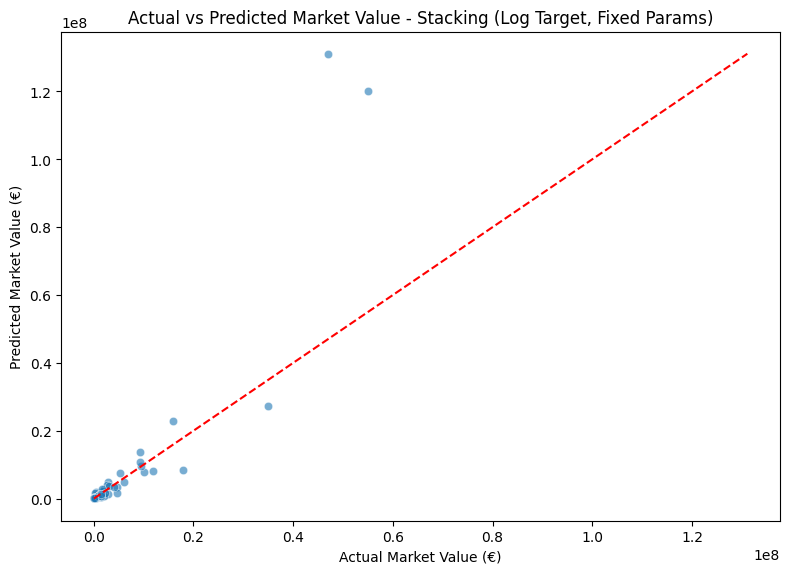

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suppress warnings from Ridge
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------------------------------------------------
# Define Plot Directory
# ---------------------------------------------------
plot_dir = "plots/gk_stacking_fixed_log"
os.makedirs(plot_dir, exist_ok=True)

# ---------------------------------------------------
# Drop corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
print("⚠️ Dropping corrupted/nested columns:", corrupted_cols)

X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# Impute missing values with median
# ---------------------------------------------------
imputer = SimpleImputer(strategy='median')
X_train_clean = pd.DataFrame(imputer.fit_transform(X_train_clean), columns=X_train_clean.columns)
X_test_clean  = pd.DataFrame(imputer.transform(X_test_clean), columns=X_test_clean.columns)

# ---------------------------------------------------
# Log-transform the target
# ---------------------------------------------------
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# ---------------------------------------------------
# Fixed Base and Meta Learners
# ---------------------------------------------------
rf_best = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

xgb_best = XGBRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

meta_learner = make_pipeline(
    StandardScaler(),
    Ridge(alpha=10.0)
)

stack = StackingRegressor(
    estimators=[('rf', rf_best), ('xgb', xgb_best)],
    final_estimator=meta_learner,
    passthrough=True
)

# ---------------------------------------------------
# Train model and predict
# ---------------------------------------------------
stack.fit(X_train_clean, y_train_log)
y_pred_log = stack.predict(X_test_clean)
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

# ---------------------------------------------------
# Metrics
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# Log-scale metrics
mae_log = mean_absolute_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2_log = r2_score(y_test_log, y_pred_log)
rmspe_log = rmspe(y_test_log,y_pred_log)
# Normal-scale metrics
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)
rmspe_val = rmspe(y_test_original.reset_index(drop=True), pd.Series(y_pred))

# ---------------------------------------------------
# Print Metrics
# ---------------------------------------------------
print("\n📊 Stacking Regressor Performance (Log Target, Fixed Best Params):")
print(f"MAE (log): {mae_log:.3f}")
print(f"RMSE (log): {rmse_log:.3f}")
print(f"R² (log): {r2_log:.3f}")
print(f"RMSPE: {rmspe_log:.2f}")

print("\n📊 Stacking Regressor Performance (Original Scale):")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")
print(f"RMSPE: {rmspe_val:.2f}%")

# ---------------------------------------------------
# Plot: Actual vs Predicted
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_original, y=y_pred, alpha=0.6)
lims = [min(y_test_original.min(), y_pred.min()), max(y_test_original.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - Stacking (Log Target, Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_stacking_fixed_log.png"))
plt.show()
